In [260]:
%load_ext autoreload
%autoreload 2 
# !apt-get install -y xvfb
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split
from torch_geometric.data import Data, InMemoryDataset
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle
import random
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [239]:


def set_device_and_seed(GPU=True, seed=0, gpu_name = "cuda:0"):
    torch.cuda.is_available()
    if GPU:
        device = torch.device(gpu_name if torch.cuda.is_available() else 'cpu')
    else:
        device = torch.device("cpu")
    print(f'Using {device}')

    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        
    set_seed(seed)
    
    return device

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    print(f"Setting torch, cuda, numpy and random seeds to {seed}")


def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

    
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [11]:
# Setting random seed and device
GPU = True # Choose whether to use GPU
set_device_and_seed(GPU=True, seed=0, gpu_name='cuda')

Using cuda
Setting torch, cuda, numpy and random seeds to 0


device(type='cuda')

### Load Data


In [23]:
pilot_df = pd.read_excel(os.path.abspath("/home/sneha/airway_tree_pilot.xlsx"), sheet_name=0)
pilot_df.drop(columns = ["manufacturer", "model"], inplace=True)

In [24]:
label_df = pd.read_csv(os.path.abspath("/home/sneha/MESA_Exam5_airway_variants.csv"))

In [25]:
label_df.sum()

idno                                                  17397820297
LL_1            StandardStandardStandardStandardStandardAcc. B...
Standard                                                     2304
Acc_B                                                         455
Abs_RB7                                                       175
Acc_LB7                                                        53
Rare                                                            2
Unclassified                                                  185
dtype: object

In [22]:
pilot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77683 entries, 0 to 77682
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   idno               77683 non-null  int64  
 1   anatomicalname     77683 non-null  object 
 2   startbpid          77683 non-null  int64  
 3   endbpid            77683 non-null  int64  
 4   centerlinelength   77683 non-null  float64
 5   angle              77454 non-null  float64
 6   dircosx            77683 non-null  float64
 7   dircosy            77683 non-null  float64
 8   dircosz            77683 non-null  float64
 9   avginnerarea       77683 non-null  float64
 10  lobes              77683 non-null  object 
 11  generation         77683 non-null  int64  
 12  weibel_generation  77683 non-null  int64  
 13  manufacturer       77683 non-null  object 
 14  model              77683 non-null  object 
dtypes: float64(6), int64(5), object(4)
memory usage: 8.9+ MB


## Make a tiny graph sample & visualise in networkx

In [347]:
single_test = pilot_df[(pilot_df.idno ==3011950) & (pilot_df.weibel_generation <= 3)].copy().reset_index().drop(columns='index')
single_test.fillna(0, inplace=True)


In [348]:
# NODE FEATURES ARE WRONG!!!
single_test['x_diff'] = (single_test.centerlinelength*single_test.dircosx)
single_test['y_diff'] = (single_test.centerlinelength*single_test.dircosy)
single_test['z_diff'] = (single_test.centerlinelength*single_test.dircosz)

single_test

,idno,anatomicalname,startbpid,endbpid,centerlinelength,angle,dircosx,dircosy,dircosz,avginnerarea,lobes,generation,weibel_generation,x_diff,y_diff,z_diff
0,3011950,Trachea,-1,1,82.03930,0.0000,-0.012990,0.194850,0.980747,237.7040,CEN,0,0,-1.065691,15.985358,80.459797
1,3011950,RMB,1,6,23.64560,144.8070,-0.498729,-0.142494,0.854965,140.5670,CEN,1,1,-11.792746,-3.369356,20.216160
2,3011950,LMB,1,7,50.79000,127.0430,0.787070,0.049192,0.614899,97.7085,CEN,1,1,39.975285,2.498457,31.230720
3,3011950,BronInt,6,19,19.75500,162.0700,-0.260820,0.026082,0.965035,108.4940,CEN,2,2,-5.152499,0.515250,19.064266
4,3011950,RUL,6,18,13.97160,98.7818,-0.904762,-0.190476,-0.380952,60.5322,RUL,2,2,-12.640973,-2.661254,-5.322509
5,3011950,LUL,7,11,12.09850,115.3660,0.832050,-0.443760,-0.332820,60.5433,LUL,2,2,10.066557,-5.368830,-4.026623
6,3011950,LLB6,7,10,8.43446,165.4590,0.745356,0.298142,0.596285,146.8000,LLL,2,2,6.286675,2.514667,5.029342
7,3011950,LLB,10,15,9.92149,161.2140,0.577350,0.115470,0.808290,40.2393,LLL,3,3,5.728172,1.145634,8.019441
8,3011950,LB6,10,14,8.46466,114.7760,0.401610,0.883541,-0.240966,24.9217,LLL,3,3,3.399492,7.478874,-2.039695
9,3011950,-,11,17,10.52590,147.6560,0.498464,-0.387694,-0.775388,38.2976,LUL,3,3,5.246782,-4.080828,-8.161657


In [148]:
# nodes and features: TODO include all features relevant + NORMALISE
nodes = list(zip(single_test.endbpid, single_test[['x', 'y', 'z','weibel_generation', 'angle']].to_dict(orient='records')))
nodes =[(-1,
  {'x': 0,
   'y': 0,
   'z': 0,
   'weibel_generation': -1,
   'angle': 0.0})]+nodes

In [149]:
# edges and features: TODO include all features relevant + NORMALISE
edges = list(zip(single_test.startbpid, single_test.endbpid))
edges_with_features = dict(zip(edges,single_test[['centerlinelength', 'avginnerarea']].to_dict(orient='records')))
edges_with_features

{(-1, 1): {'centerlinelength': 82.0393, 'avginnerarea': 237.704},
 (1, 6): {'centerlinelength': 23.6456, 'avginnerarea': 140.567},
 (1, 7): {'centerlinelength': 50.79, 'avginnerarea': 97.7085},
 (6, 19): {'centerlinelength': 19.755, 'avginnerarea': 108.494},
 (6, 18): {'centerlinelength': 13.9716, 'avginnerarea': 60.5322},
 (7, 11): {'centerlinelength': 12.0985, 'avginnerarea': 60.5433},
 (7, 10): {'centerlinelength': 8.43446, 'avginnerarea': 146.8},
 (10, 15): {'centerlinelength': 9.92149, 'avginnerarea': 40.2393},
 (10, 14): {'centerlinelength': 8.46466, 'avginnerarea': 24.9217},
 (11, 17): {'centerlinelength': 10.5259, 'avginnerarea': 38.2976},
 (11, 16): {'centerlinelength': 11.1299, 'avginnerarea': 28.5548},
 (18, 28): {'centerlinelength': 7.33379, 'avginnerarea': 42.1697},
 (18, 29): {'centerlinelength': 6.53103, 'avginnerarea': 36.133},
 (19, 30): {'centerlinelength': 18.0194, 'avginnerarea': 34.9124},
 (19, 31): {'centerlinelength': 6.1641, 'avginnerarea': 77.5104}}

[(-1, 1, {'centerlinelength': 82.0393, 'avginnerarea': 237.704}), (1, 6, {'centerlinelength': 23.6456, 'avginnerarea': 140.567}), (1, 7, {'centerlinelength': 50.79, 'avginnerarea': 97.7085}), (6, 19, {'centerlinelength': 19.755, 'avginnerarea': 108.494}), (6, 18, {'centerlinelength': 13.9716, 'avginnerarea': 60.5322}), (7, 11, {'centerlinelength': 12.0985, 'avginnerarea': 60.5433}), (7, 10, {'centerlinelength': 8.43446, 'avginnerarea': 146.8}), (19, 30, {'centerlinelength': 18.0194, 'avginnerarea': 34.9124}), (19, 31, {'centerlinelength': 6.1641, 'avginnerarea': 77.5104}), (18, 28, {'centerlinelength': 7.33379, 'avginnerarea': 42.1697}), (18, 29, {'centerlinelength': 6.53103, 'avginnerarea': 36.133}), (11, 17, {'centerlinelength': 10.5259, 'avginnerarea': 38.2976}), (11, 16, {'centerlinelength': 11.1299, 'avginnerarea': 28.5548}), (10, 15, {'centerlinelength': 9.92149, 'avginnerarea': 40.2393}), (10, 14, {'centerlinelength': 8.46466, 'avginnerarea': 24.9217})]
[(-1, {'x': 0, 'y': 0, 'z

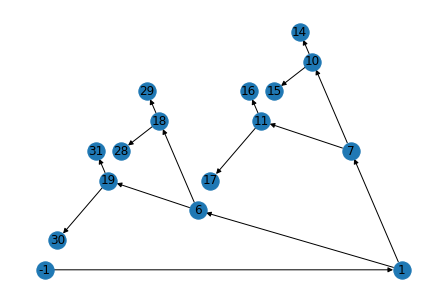

In [150]:
g = nx.DiGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
nx.set_edge_attributes(g,edges_with_features)
print(g.edges(data=True))
print(g.nodes(data=True))
# 2D projection of tree (excluding the trachea itself)
nx.draw_planar(g,with_labels=True)

## Pytorch Dataset for Geometric

In [224]:
x_list_plus_trachea = [[0,0,0,-1]]+ single_test.apply(lambda row:row[['x','y','z', 'weibel_generation']].to_list(), axis=1).to_list() # here only node features are pos and weibel gen
x = torch.tensor(x_list_plus_trachea, dtype=torch.float)
x.shape

torch.Size([16, 4])

In [219]:
# edges
# relabel_map = dict(zip(single_test.endbpid,np.arange(1,len(single_test))))
relabel_map = {v:k+1 for k,v in single_test.endbpid.to_dict().items()}
# single_test.startbpid.apply(lambda x: if x== -1 relabel_map[x])
relabel_map[-1] = 0
relabel_map
source_nodes = single_test.startbpid.apply(lambda x: relabel_map[x]).to_list()
end_nodes = single_test.endbpid.apply(lambda x: relabel_map[x]).to_list()
source_nodes, end_nodes

([0, 1, 1, 2, 2, 3, 3, 7, 7, 6, 6, 5, 5, 4, 4],
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [225]:
edge_index = torch.tensor([source_nodes, end_nodes], dtype=torch.long)
edge_index.shape

torch.Size([2, 15])

In [285]:
data = Data(x=x, y=torch.FloatTensor([0]),edge_index=edge_index)

In [281]:
data

Data(x=[16, 4], edge_index=[2, 15], y=0)

In [282]:
nodes = torch.tensor([0,0,0,-1]+ x )

TypeError: can only concatenate list (not "Tensor") to list

OutEdgeView([(0, 1), (1, 2), (1, 3), (2, 4), (2, 5), (3, 6), (3, 7), (4, 14), (4, 15), (5, 12), (5, 13), (6, 10), (6, 11), (7, 8), (7, 9)])

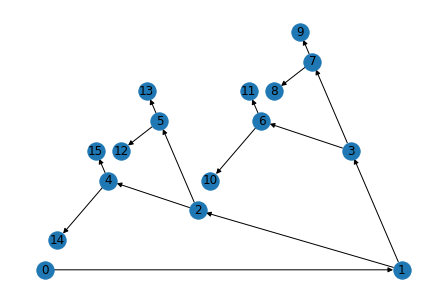

In [283]:
import torch_geometric
g = torch_geometric.utils.to_networkx(data, to_undirected=False)
nx.draw_planar(g, with_labels=True)
g.edges()


tensor([0, 1, 0, 1])
DataDataBatch(x=[256, 4], edge_index=[2, 240], y=[16], batch=[256]) defaultdict(<class 'dict'>, {'x': tensor([  0,  64, 128, 192, 256]), 'edge_index': tensor([  0,  60, 120, 180, 240]), 'y': tensor([ 0,  4,  8, 12, 16]), 'batch': tensor([  0,  64, 128, 192, 256])})
FIRST 60


(0,
 [DataBatch(x=[256, 4], edge_index=[2, 240], y=[16], batch=[256]),
  tensor([0, 1, 0, 1])])

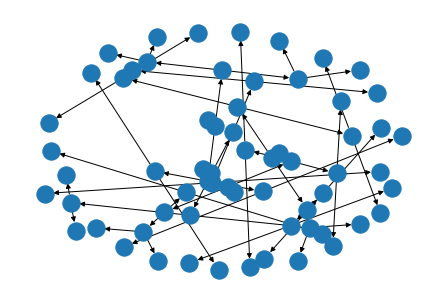

In [345]:
from torch_geometric.loader import DataLoader
# https://www.youtube.com/watch?v=QLIkOtKS4os --> creating custom dataset in pytorch geometric


class CustomDataset(InMemoryDataset):
    def __init__(self,data_in,label_in, transform=None):
        self.data_list = data_in
        self.labels = torch.tensor(label_in)
        print(self.labels)
        self.data, self.slices = self.collate(data_in)
        print(self.data, self.slices)
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, index):
        return self.data_list[index], self.labels[index]
    
    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)
        
my_data  = CustomDataset(data_in=[data, data, data,data], label_in=[0,1,0,1])
first = my_data[0]
print("FIRST",first[0].num_edges)
g = torch_geometric.utils.to_networkx(first[0], to_undirected=False)
nx.draw(g)
loader = DataLoader(my_data, batch_size=20)
next(enumerate(loader))

In [333]:


class GCN(torch.nn.Module):
    def __init__(self,in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        print(x.shape)
        x = self.conv1(x, edge_index)
        print(x.shape)
        x = x.relu()
        x = self.conv2(x, edge_index)
        print(x.shape)
        x = x.relu()
        x = self.conv3(x, edge_index)
        print(x.shape)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(in_channels=4, hidden_channels=2, out_channels=1)
print(model)

GCN(
  (conv1): GCNConv(4, 2)
  (conv2): GCNConv(2, 2)
  (conv3): GCNConv(2, 2)
  (lin): Linear(in_features=2, out_features=1, bias=True)
)


In [336]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
 
for batch_idx, (data, label) in list(enumerate(loader)):
    print(data, label)
    x = model(data.x, data.edge_index,data.batch)
    print("HERE", x.shape, torch.sigmoid(x))
    print("label", data.y)
    loss =criterion(torch.sigmoid(x), data.y.unsqueeze(-1))
    print("loss", loss)
    loss.backward()

DataBatch(x=[64, 4], edge_index=[2, 60], y=[4], batch=[64]) tensor([0, 1])
torch.Size([64, 4])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
HERE torch.Size([4, 1]) tensor([[0.4218],
        [0.4214],
        [0.4214],
        [0.4214]], grad_fn=<SigmoidBackward0>)
label tensor([0., 0., 0., 0.])
loss tensor(-0., grad_fn=<DivBackward1>)
DataBatch(x=[64, 4], edge_index=[2, 60], y=[4], batch=[64]) tensor([0, 1])
torch.Size([64, 4])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
HERE torch.Size([4, 1]) tensor([[0.4218],
        [0.4218],
        [0.4214],
        [0.4214]], grad_fn=<SigmoidBackward0>)
label tensor([0., 0., 0., 0.])
loss tensor(-0., grad_fn=<DivBackward1>)
